# Part II: Road Lane Detection Using Hough Transform

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def find_edges(img,th1,th2):
    grayscale = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    denoised = cv2.medianBlur(grayscale,5)
    canny = cv2.Canny(denoised,th1,th2)
    return canny

In [23]:
def roi(img,bl=1,tl=0.5,br=(0.9,1),tr=(0.6,0.45)):
    height,width = img.shape[:2]
    roi_bottom_left = (0, height*bl)  
    roi_top_left = (0, height * tl)
    roi_top_right = (width * tr[0], height * tr[1])
    roi_bottom_right = (width * br[0], height*br[1])
    
    vertices = np.array([[roi_bottom_left, roi_top_left, roi_top_right, roi_bottom_right]], dtype=np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, (255, 255, 255)) 
    roi_img = cv2.bitwise_and(img, mask)
    
    return roi_img,vertices

In [312]:
def display(img_path,bl=1,tl=0.5,br=(0.9,1),tr=(0.6,0.45)):
    img = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(25,10))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Original Image')

    canny = find_edges(img,100,170)
    plt.subplot(1,3,2)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny Edge Detection')

    roi_img,poly = roi(canny,bl,tl,br,tr)
    plt.subplot(1,3,3)
    plt.imshow(roi_img, cmap='gray')
    plt.title('Region of Interest')
    plt.show()
    return img,roi_img,poly

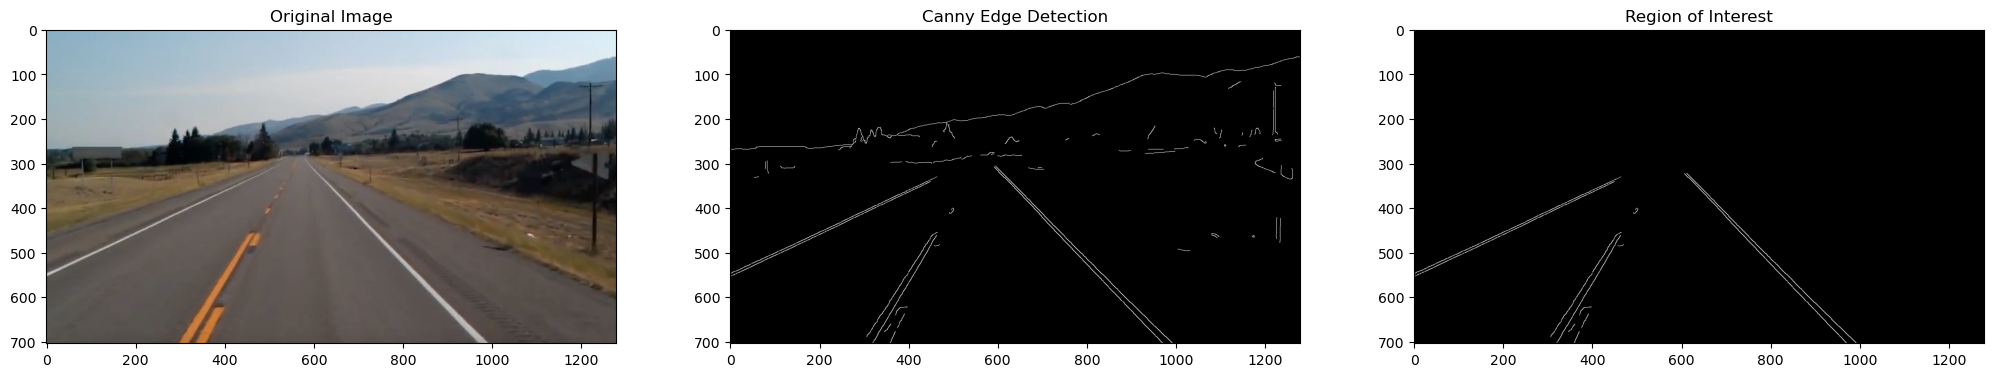

In [313]:
img1,roi_img1,poly1 = display('Lanes/lane_1.jpg')

In [314]:
def non_max_suppression(rhos,thetas,H, rho_tolerance, theta_tolerance):
    retained_rhos=[]
    retained_thetas=[]
    point = np.unravel_index(np.argmax(H), H.shape)
    retained_rhos.append(point[0])
    retained_thetas.append(point[1])

    for rho,theta in zip(rhos[1:],thetas[1:]):
        if all(not np.isclose(rho, r, atol=rho_tolerance) or not np.isclose(theta, t, atol=theta_tolerance) for r, t in zip(retained_rhos,retained_thetas)):
            retained_thetas.append(theta)
            retained_rhos.append(rho)

    return retained_rhos,retained_thetas

In [315]:
def hough(img, threshold = 100):
    rhos =[]
    thetas = []
    max_rho = int((np.ceil(np.sqrt((img.shape[0])**2 + (img.shape[1])**2))))
    accumulator = np.zeros((max_rho, 180))
    edge_points = np.argwhere(img>150)
    
    for point in edge_points:
        for theta in range(0,180):
            theta_rad= np.radians(theta)
            rho = point[1]* np.cos(theta_rad) + point[0] * np.sin(theta_rad)
            rho = round((rho))                  
            accumulator[rho,theta] += 1

            if accumulator[rho,theta] >= threshold:
                rhos.append(rho)
                thetas.append(theta) 
                                          
    return rhos, thetas, accumulator

In [316]:
def detect_lanes(img, poly,rhos,thetas):
  mask_lines = np.zeros(img.shape, dtype="uint8")   
  for i in range(len(rhos)):
      rho = rhos[i]
      theta = np.deg2rad(thetas[i])
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho
      x1 = int(x0 + 1500*(-b))
      y1 = int(y0 + 1500*(a))
      x2 = int(x0 - 1500*(-b))
      y2 = int(y0 - 1500*(a))

      cv2.line(mask_lines,(x1,y1),(x2,y2),(0,255,0),3)

  mask = np.zeros_like(mask_lines)
  cv2.fillPoly(mask,poly,(255,255,255))
  masked_img=cv2.bitwise_and(mask_lines,mask)
  overlay = cv2.addWeighted(img, 1, masked_img, 1, 0)
  return overlay

In [317]:
rhos,thetas,H = hough(roi_img1)
output = detect_lanes(img1,poly1,rhos,thetas)
ret_rhos,ret_thetas = non_max_suppression(rhos,thetas,H,60,20)
refined_output= detect_lanes(img1,poly1,ret_rhos,ret_thetas)

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

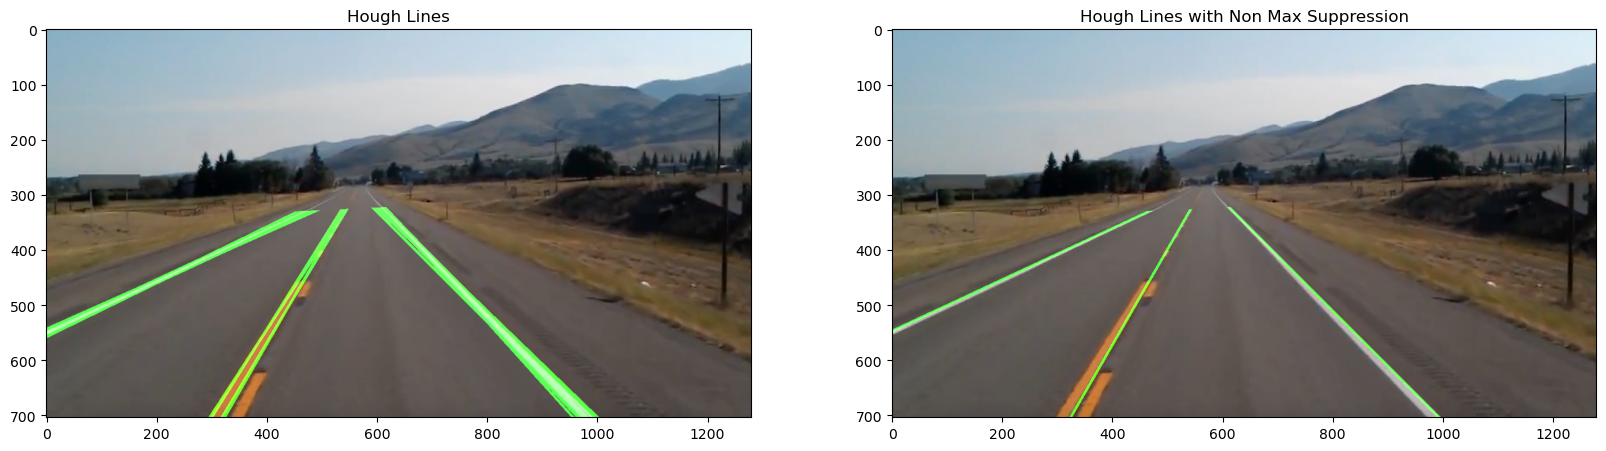

In [318]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(output)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(refined_output)
plt.title('Hough Lines with Non Max Suppression')

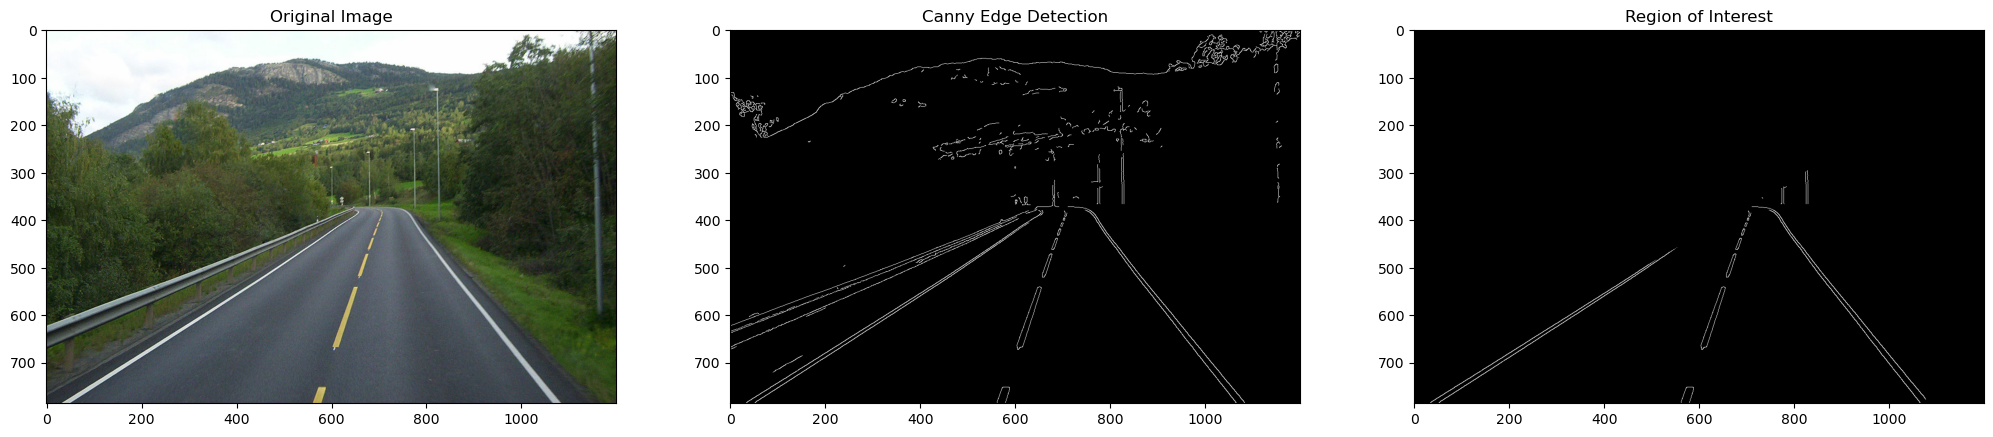

In [346]:
img2,roi_img2,poly2=display('Lanes/lane_3.jpg',1,1,(0.9,1),(0.7,0.37))

Text(0.5, 1.0, 'Hough Lines with Non Max Suppression')

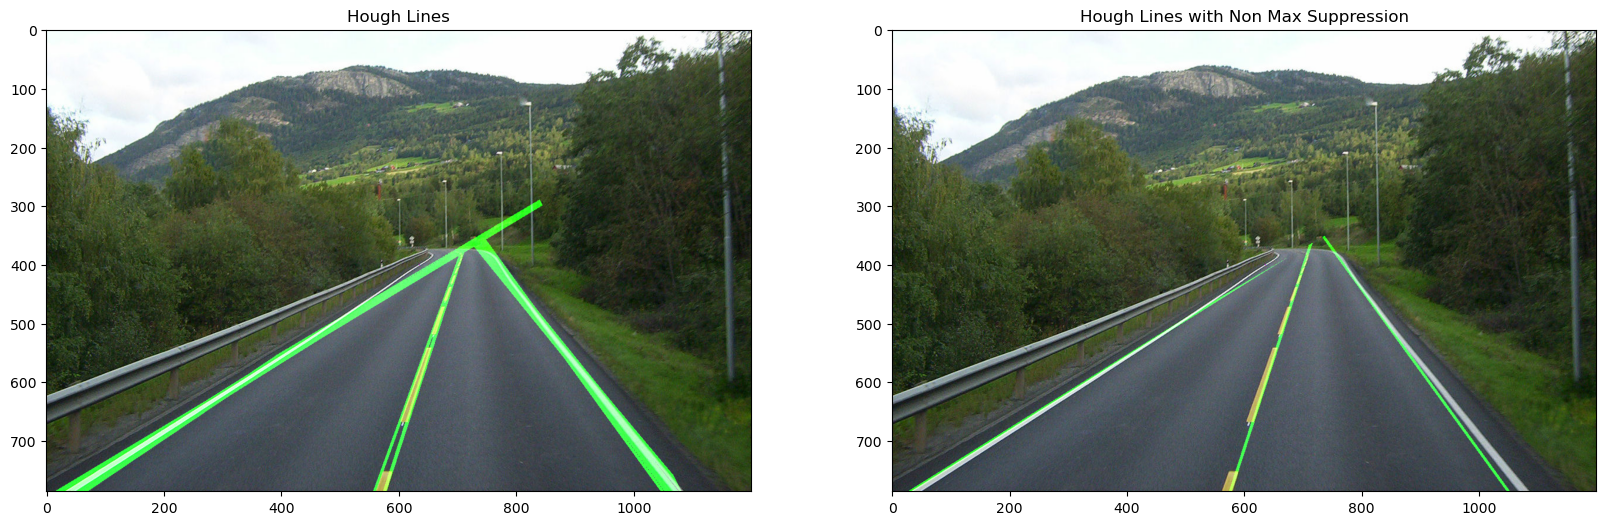

In [348]:
rhos,thetas,H = hough(roi_img2)
output2 = detect_lanes(img2,poly2,rhos,thetas)
ret_rhos,ret_thetas = non_max_suppression(rhos,thetas,H,80,30)
refined_output2= detect_lanes(img2,poly2,ret_rhos,ret_thetas)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(output2)
plt.title('Hough Lines')

plt.subplot(1,2,2)
plt.imshow(refined_output2)
plt.title('Hough Lines with Non Max Suppression')